In [ ]:
import numpy as np
import scipy.special 
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def get_nparameters(l_max):
    return generate_complex_reflectivity(16, l_max)[0].shape[1]

def generate_complex_reflectivity(resolution, l_max):
    theta, phi = np.linspace(0, 2 * np.pi, num=resolution), np.linspace(0, np.pi, num=resolution)
    theta, phi = np.meshgrid(theta, phi)
    theta, phi = theta.reshape((-1)), phi.reshape((-1))

    def generate_decay(m, l):
        decay = scipy.special.sph_harm(m, l, theta, phi)
        inv_decay = -1 ** m * scipy.special.sph_harm(-m, l, theta, phi)
        return decay, inv_decay

    decays = []
    labels = []
    for l in range(1, l_max + 1):  # Loop from 1 to Lmax

        decay, inv_decay = generate_decay(m=0, l=l)
        decays.append(decay - inv_decay)
        labels.append((-1, l, 0))

        decay, inv_decay = generate_decay(m=1, l=l)
        decays.append(decay - inv_decay)
        labels.append((-1, l, 1))

        decays.append(decay + inv_decay)
        labels.append((+1, l, 1))

    decays = np.array(decays).reshape((1, len(decays), -1))
    return decays, phi, theta, labels


def combo(put):
    return np.matmul(put[:, np.newaxis], put.conj()[np.newaxis, :])


def combine(decays, p_amps):
    return np.sum(np.multiply(decays, p_amps), axis=(1, 2))


decay_matrix = None
combo_v = np.vectorize(combo, signature='(n)->(m,n)')
combine_v = np.vectorize(combine, signature='(m,n),(j,m,n)->(j)')


def get_decays(resolution, l_max):
    global decay_matrix
    if decay_matrix is None:
        decays, *_ = generate_complex_reflectivity(resolution, l_max)
        decays = np.squeeze(decays).T
        decays = combo_v(decays)
        decays = np.array(decays, dtype=np.complex64)
        decay_matrix = decays

    return decay_matrix


def generate_complex_weights(batch_size, nparameters):
    complex_weights = np.random.uniform(-1, 1, (batch_size, nparameters)) + \
              np.random.uniform(-1, 1, (batch_size, nparameters)) * 1j

    magnitude, phase = np.absolute(complex_weights), np.angle(complex_weights)
    phase[:, 0] = 0
    np.clip(magnitude, 0, 1, out=magnitude)

    complex_weights = magnitude * np.cos(phase) + magnitude * np.sin(phase) * 1j
    return complex_weights

def create_histogram(resolution, l_max, p_amps):
    batch_size = p_amps.shape[0]

    decays = get_decays(resolution, l_max)
    p_amps_matrix = combo_v(p_amps)
    histogram = combine_v(p_amps_matrix, decays)
    histogram = histogram.real
    # histogram /= np.sum(histogram, axis=-1, keepdims=True)

    return histogram.reshape((batch_size, resolution, resolution, 1))

def generate_sample(model):
    nparameters = get_nparameters(model)
    weights = generate_complex_weights(1, nparameters)
    histogram = create_histogram(model, weights)
    return weights, histogram

def complex_generator(resolution, l_max, batch_size):
    nparameters = get_nparameters(l_max)
    while True:
        weights = generate_complex_weights(batch_size, nparameters)
        histogram = create_histogram(resolution, l_max, weights)
        yield histogram, weights

def hist_to_hist_generator(model, batch_size):
    nparameters = get_nparameters(model)
    while True:
        weights, *_ = generate_complex_weights(batch_size, nparameters)
        histogram = create_histogram(model, weights)
        yield histogram, histogram

In [ ]:
if __name__ == '__main__':
    l_max = 2
    n_param = get_nparameters(l_max)
    np.random.seed(0)
    p_amps = generate_complex_weights(5000, n_param)
    histograms = create_histogram(128, l_max, p_amps)
    print(histograms.shape)
    print(p_amps.shape)

(5000, 128, 128, 1)
(5000, 6)


In [ ]:
p_amps[0]

array([ 0.52540076+0.j        ,  0.43037873+0.00663702j,
        0.20552675-0.64596667j,  0.08976637+0.66507301j,
       -0.1526904 +0.03364956j,  0.29178823+0.85383909j])

In [ ]:
histograms[0].shape

(128, 128, 1)

In [ ]:
a = histograms[8]
a = a.reshape((128,128))
a  = a * 256

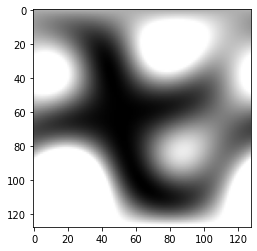

In [ ]:
img = Image.fromarray(a)
plt.imshow(img)
plt.show()

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt


import os
import numpy as np
import cv2

In [ ]:
from keras.models import Sequential, Model

from keras.layers import Dense, Conv2D, Conv2DTranspose, Input, Flatten, BatchNormalization, Lambda, Reshape, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import selu
from keras.layers import Multiply, Add


from keras import backend as K

In [ ]:
batch_size = 32

training_dataset = tf.data.Dataset.from_tensor_slices(histograms)
training_dataset = training_dataset.shuffle(1000).batch(batch_size)

In [ ]:
len(training_dataset)

157

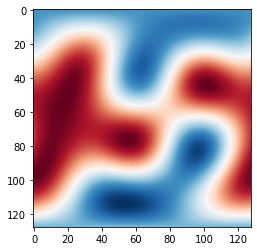

In [ ]:
# visualize some of them
# fig, axes = plt.subplots(5,5, figsize = (14,14))
sample = training_dataset.unbatch().take(1)
sample = [image for image in sample]
re = tf.reshape(sample,(128,128))
plt.imshow(re,cmap = 'RdBu')
# idx = 0
# for row in range(5):
#     for column in range(5):
#         re = tf.reshape(sample[idx],(128,128))
#         axes[row, column].imshow(re,cmap = 'RdBu')
#         idx+=1

In [ ]:
# build the model

latent_dim = 512

In [ ]:
K.clear_session()

In [ ]:
encoder_input = Input(shape = (128,128,1))

x = Conv2D(32, kernel_size=5, activation = LeakyReLU(0.02), strides = 1, padding = 'same')(encoder_input)
x = BatchNormalization()(x)

filter_size = [128,256,512,1028]
for i in filter_size:
    x = Conv2D(i, kernel_size=5, activation = LeakyReLU(0.02), strides = 2, padding = 'same')(x)
    x = BatchNormalization()(x)

x = Flatten()(x)
x = Dense(2028, activation = selu)(x)
x = BatchNormalization()(x)

x = Dense(1024, activation = selu)(x)
encoder_output = BatchNormalization()(x)

# sampling layer
mu = Dense(latent_dim)(encoder_output)
log_var = Dense(latent_dim)(encoder_output)

epsilon = K.random_normal(shape = (tf.shape(mu)[0], tf.shape(mu)[1]))
sigma = tf.exp(0.5 * log_var)

z_eps = Multiply()([sigma, epsilon])
z = Add()([mu, z_eps])

encoder = Model(encoder_input, outputs = [mu, log_var, z], name = 'encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  832         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                           

In [ ]:
# build the decoder

decoder = Sequential()
decoder.add(Dense(1024, activation = selu, input_shape = (latent_dim, )))
decoder.add(BatchNormalization())

decoder.add(Dense(8192, activation = selu))
decoder.add(Reshape((4,4,512)))

decoder.add(Conv2DTranspose(256, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(128, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(64, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(32, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(16, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())


decoder.add(Conv2DTranspose(1, (5,5), activation = "sigmoid", strides = 1, padding = 'same'))
decoder.add(BatchNormalization())

decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              525312    
                                                                 
 batch_normalization_7 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 8192)              8396800   
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        3277056   
 nspose)                                                         
                                                                 
 batch_normalization_8 (Batc  (None, 8, 8, 256)        1

In [ ]:
# make loss function 
# vae loss = reconstruction loss + KL div

def reconstruction_loss(y, y_pred):
    return tf.reduce_mean(tf.square(y - y_pred))

def kl_loss(mu, log_var):
    loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))
    return loss

def vae_loss(y_true, y_pred, mu, log_var):
  return reconstruction_loss(y_true, y_pred) + (1 / (128*128)) * kl_loss(mu, log_var)

In [ ]:

# conbine encoder and decoder
mu, log_var, z = encoder(encoder_input)
reconstructed = decoder(z)
model = Model(encoder_input, reconstructed, name ="vae")
loss = kl_loss(mu, log_var)
model.add_loss(loss)
model.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 encoder (Functional)           [(None, 512),        153935088   ['input_1[0][0]']                
                                 (None, 512),                                                     
                                 (None, 512)]                                                     
                                                                                                  
 sequential (Sequential)        (None, 128, 128, 1)  13293893    ['encoder[1][2]']              

In [ ]:
# # make a function to save images while learning
# def save_images(model, epoch, step, input_):
#     prediction = model.predict(input_)
#     fig, axes = plt.subplots(2,2, figsize = (14,14))
#     idx = 0
#     for row in range(2):
#         for column in range(2):
#             image = prediction[idx] * 255
#             image = image.reshape((128,128))
#             image = image.astype("int32")
#             axes[row, column].imshow(image,cmap = 'RdBu')
#             axes[row, column].axis("off")
#             idx+=1
#     output_path = "/content/drive/MyDrive/SALGADO_VAE/OT/"
#     if not os.path.exists(output_path):
#         os.mkdir(output_path)
#     plt.savefig(output_path + "Epoch_{:03d}_step_{:02d}.jpg".format(epoch, step))
#     plt.close()


In [ ]:
def save_test(epoch, step, ip_): 
    ip_ = tf.reshape(ip_, shape = (batch_size,128,128))
    fig, axes = plt.subplots(2,2, figsize = (14,14))
    idx = 0
    for row in range(2):
        for column in range(2):
            input_ = tf.multiply(ip_[idx],255)
            input_ = tf.cast(input_, tf.int32)
            axes[row, column].imshow(input_,cmap = 'RdBu')
            axes[row, column].axis("off")
            idx+=1
    output_path = "/content/drive/MyDrive/SALGADO_VAE/y_test/"
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    plt.savefig(output_path + "Epoch_{:03d}_step_{:02d}.jpg".format(epoch, step))
    plt.close()
    # tf.keras.preprocessing.image.save_img(fig,output_path + "Epoch_{:04d}_step_{:04d}.jpg".format(epoch, step))


In [ ]:
def save_pred(epoch, step, ip_): 
    ip_ = tf.reshape(ip_, shape = (batch_size,128,128))
    fig, axes = plt.subplots(2,2, figsize = (14,14))
    idx = 0
    for row in range(2):
        for column in range(2):
            input_ = tf.multiply(ip_[idx],255)
            input_ = tf.cast(input_, tf.int32)
            axes[row, column].imshow(input_,cmap = 'RdBu')
            axes[row, column].axis("off")
            idx+=1
    output_path = "/content/drive/MyDrive/SALGADO_VAE/y_pred/"
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    plt.savefig(output_path + "Epoch_{:03d}_step_{:02d}.jpg".format(epoch, step))
    plt.close()

In [ ]:

# train vae

from tensorflow.keras.optimizers import Adam

# random_vector = tf.random.normal(shape = (25, latent_dim,))
mse_losses = []
kl_losses = []
mse_losses_TOTAL = []
kl_losses_TOTAL = []

optimizer = Adam(0.0001, 0.5)
epochs = 150

for epoch in range(1, epochs + 1):
    print("Epoch: ", epoch)
    for step, training_batch in enumerate(training_dataset):
        with tf.GradientTape() as tape:
            reconstructed = model(training_batch)
          

            y_true = tf.reshape(training_batch, shape = [-1])
            y_pred = tf.reshape(reconstructed, shape = [-1])
            y_true = tf.cast(y_true, tf.float32)
            y_pred = tf.cast(y_pred, tf.float32)

            mse_loss = reconstruction_loss(y_true, y_pred)
            mse_losses.append(mse_loss.numpy())
            
            kl = sum(model.losses)
            kl_losses.append(kl.numpy())
            
            train_loss = 0.01 * kl + mse_loss
            
            grads = tape.gradient(train_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            if step == 82:
              avr_kl = sum(kl_losses) / len(kl_losses)
              avr_mse = sum(mse_losses) / len(mse_losses)

              mse_losses_TOTAL.append(avr_mse)
              kl_losses_TOTAL.append(avr_kl)

              mse_losses = []
              kl_losses = []
            
            if step == 82  and epoch%5 == 0:
                # save_images(decoder, epoch, step, random_vector)
                save_test(epoch, step, y_true)
                save_pred(epoch, step, y_pred)
                print("Epoch: %s - Step: %s - MSE loss: %s - KL loss: %s" % (epoch, step, mse_loss.numpy(), kl.numpy()))

Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch: 5 - Step: 82 - MSE loss: 0.4709481 - KL loss: 0.49459058
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch: 10 - Step: 82 - MSE loss: 0.45082134 - KL loss: 0.50134045
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch: 15 - Step: 82 - MSE loss: 0.28452325 - KL loss: 0.4700354
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch: 20 - Step: 82 - MSE loss: 0.34791335 - KL loss: 0.384937
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch: 25 - Step: 82 - MSE loss: 0.32246178 - KL loss: 0.33111882
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:  30
Epoch: 30 - Step: 82 - MSE loss: 0.22552778 - KL loss: 0.31397057
Epoch:  31
Epoch:  32
Epoch:  33
Epoch:  34
Epoch:  35
Epoch: 35 - Step: 82 - MSE loss: 0.17023434 - KL loss: 0.28427154
Epoch:  36
Epoch:  37
Epoch:  38
Epoch:  39
Epoch:  40
Epoch: 40 - Step: 82 - MSE loss: 0.2305953 - KL loss: 0.28496248
Epoch:  41
Epoch:  42
Epoch:  43
Epoch:  44
Epo

IndexError: ignored

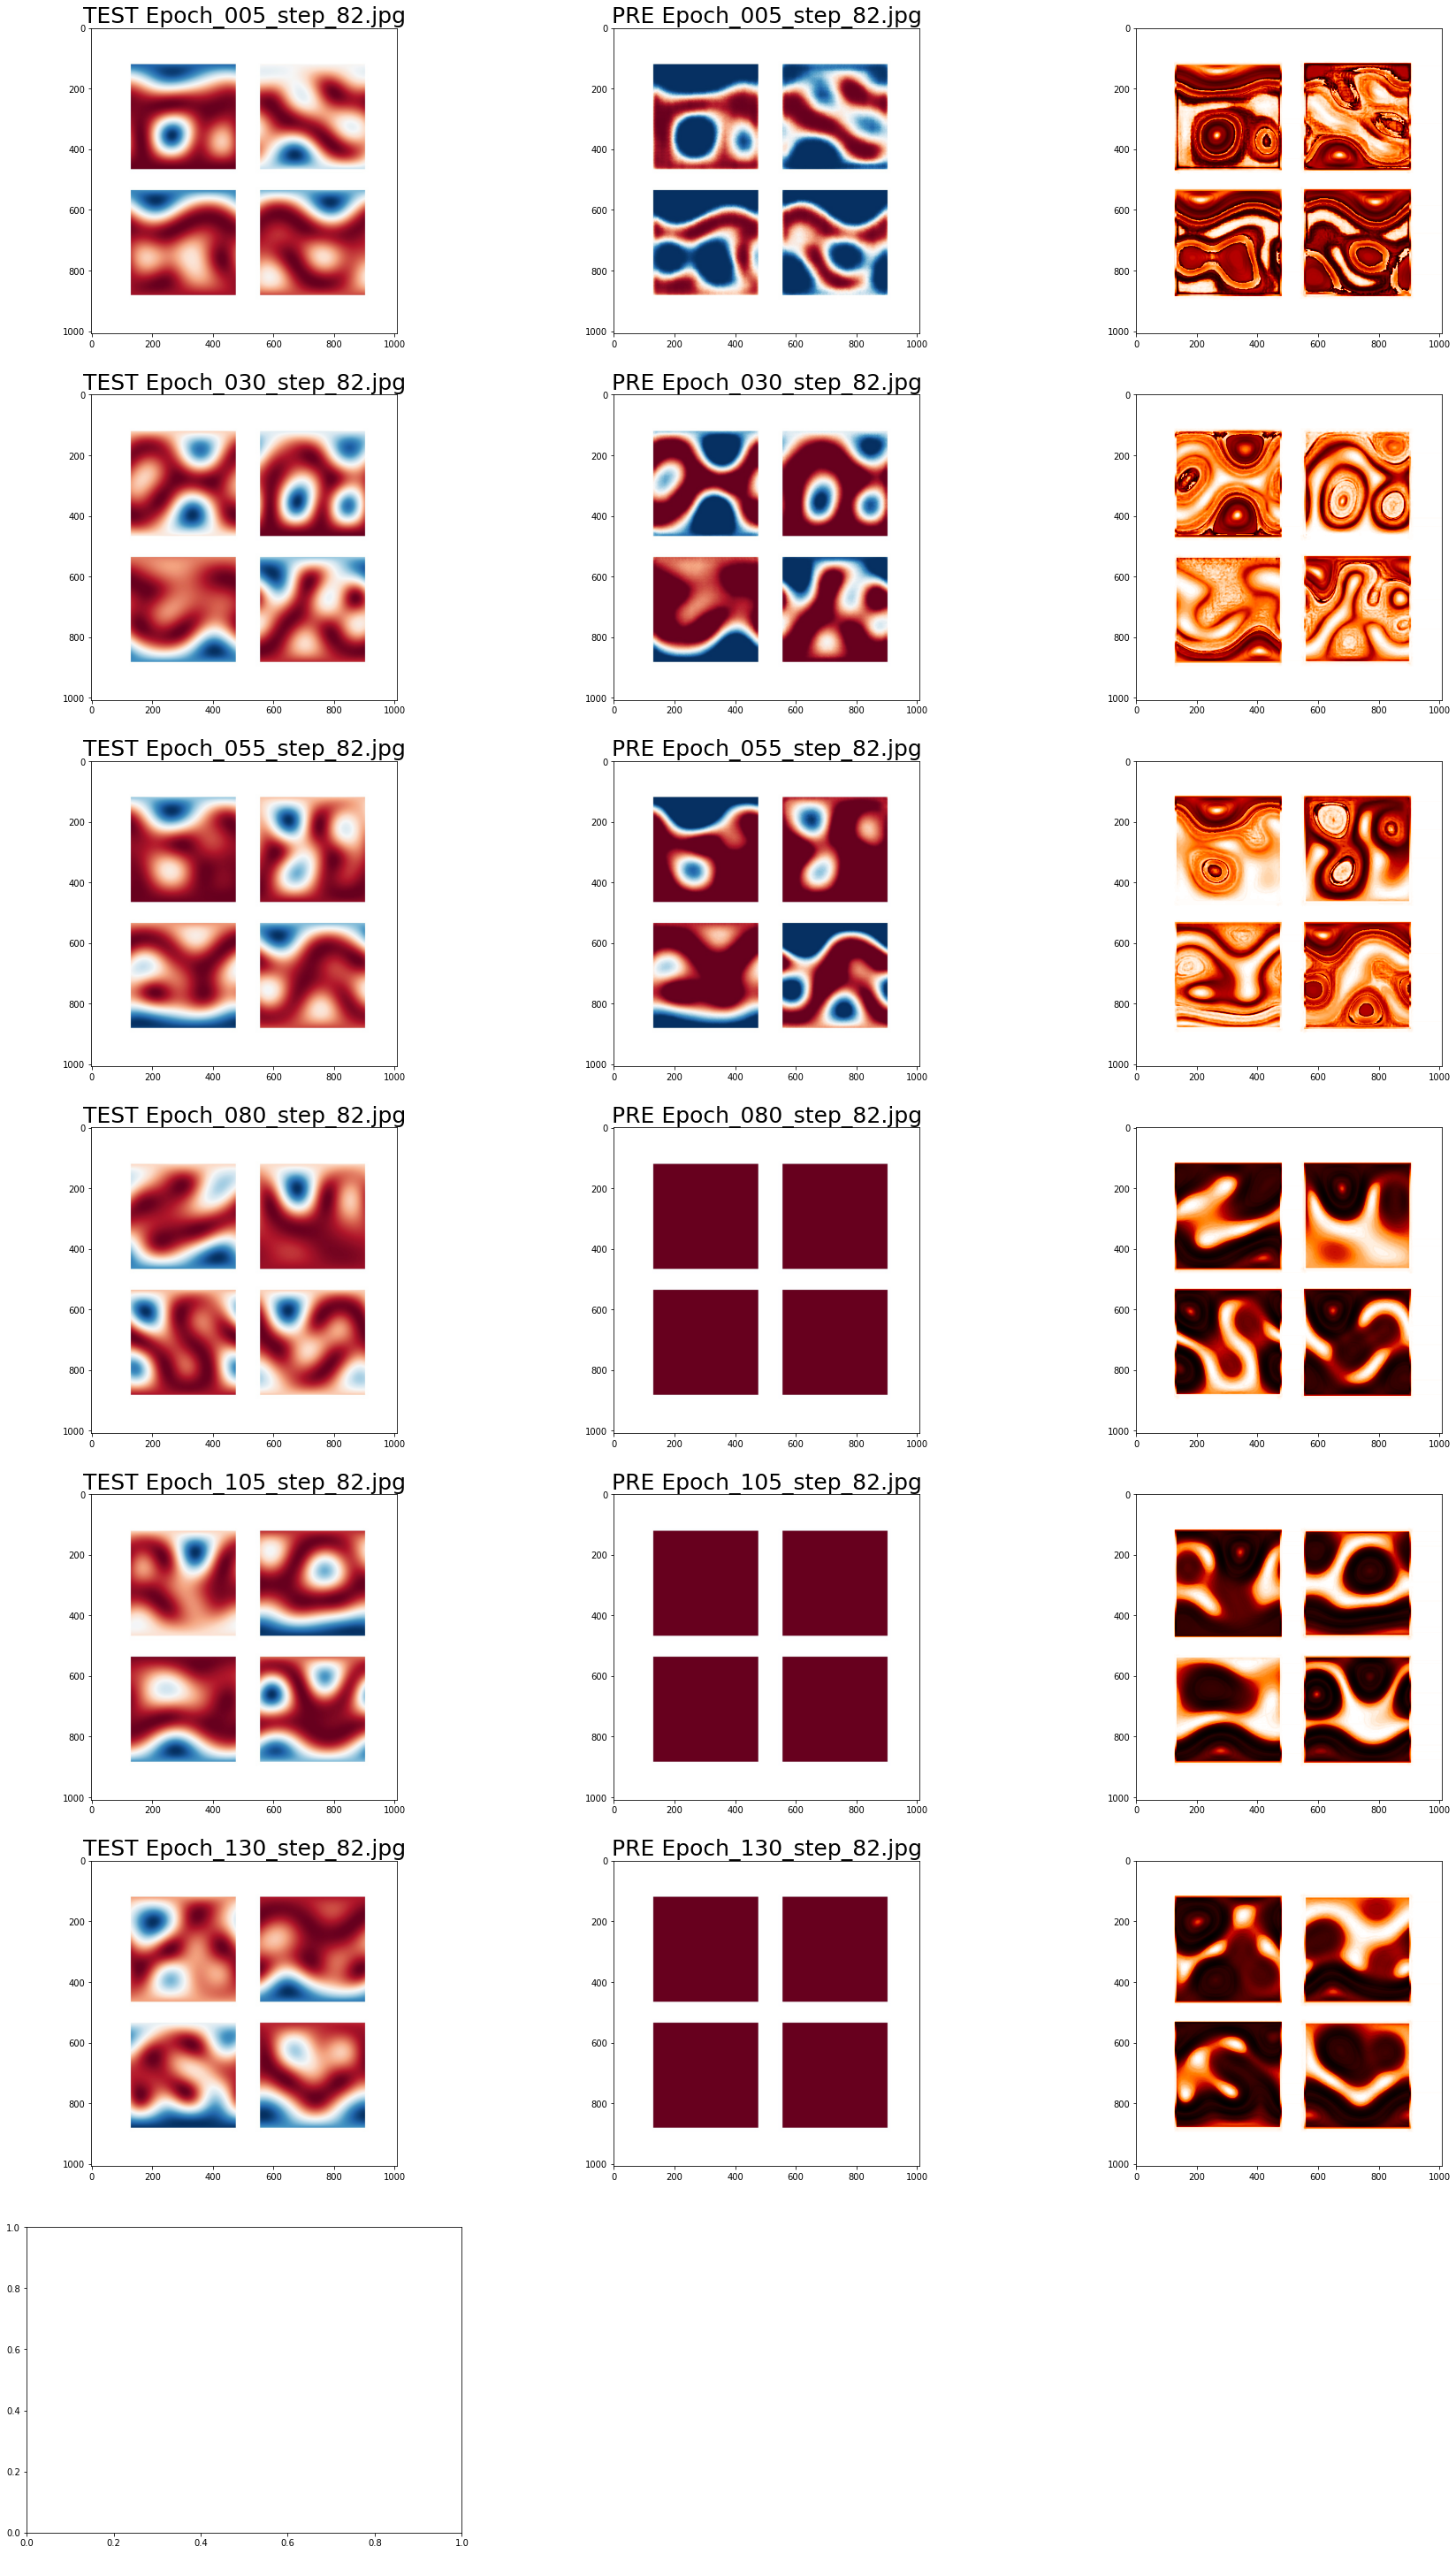

In [ ]:
from skimage.metrics import structural_similarity
import matplotlib.image as mpimg

pred_dir = "/content/drive/MyDrive/SALGADO_VAE/y_pred/"
pr = os.listdir(pred_dir)

test_dir = "/content/drive/MyDrive/SALGADO_VAE/y_test/"
ts = os.listdir(test_dir)

# OT = "/content/drive/MyDrive/SALGADO_VAE/OT/"
# ot = os.listdir(OT)

fig = plt.figure(figsize = (30,75))

#  Categorical Data
a = 10 # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter

for n in range(1,31,5):

    plt.subplot(a,b,c)
    image_t = mpimg.imread(test_dir + ts[n])
    plt.title('TEST ' + ts[n], fontsize = 25  )
    plt.imshow(image_t,cmap = 'RdBu')
    c = c + 1


    plt.subplot(a,b,c)
    image_p = mpimg.imread(pred_dir + pr[n])
    plt.title('PRE ' + pr[n], fontsize = 25  )
    plt.imshow(image_p,cmap = 'RdBu')
    c = c + 1

    plt.subplot(a,b,c)
    gray_orig = cv2.cvtColor(image_t, cv2.COLOR_BGR2GRAY)
    gray_mod = cv2.cvtColor(image_p, cv2.COLOR_BGR2GRAY)
    (score, diff) = structural_similarity(gray_orig, gray_mod, full=True)
    diff = (diff * 255).astype("uint8")
    plt.imshow(diff,cmap = 'gist_heat')
    c = c + 1



    # plt.subplot(a,b,c)
    # image_t = cv2.imread(OT + ot[n])
    # plt.imshow(image_t,cmap = 'RdBu')
    # plt.title(ot[n])
    # c = c + 1


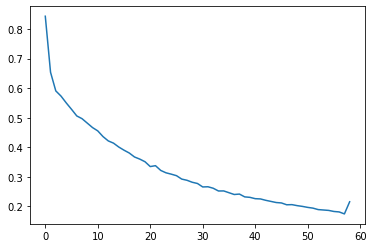

In [ ]:
plt.plot(mse_losses_TOTAL)

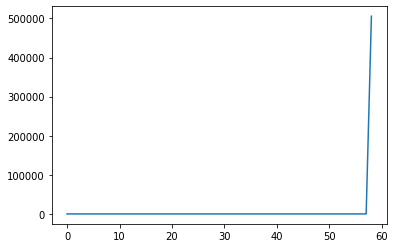

In [ ]:
plt.plot(kl_losses_TOTAL)

In [ ]:
a = histograms[5]
a = a.reshape((1,128,128,1))

In [ ]:
a = tf.data.Dataset.from_tensors(a)
# a = tf.reshape(a, shape = [-1])
# training_dataset = training_dataset.shuffle(1000).batch(batch_size)

In [ ]:
mu, log_var, z = encoder.predict(a)

In [ ]:
mu = np.mean(mu)
log_var = np.mean(log_var)

In [ ]:
mu

-0.0081033725

In [ ]:
s = np.random.normal(mu, log_var, 1000)
count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()

ValueError: ignored